## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Read-In Data

### North Atlantic Hurricane Data for the USA (1851-2020)
Source: [IBTrACS Version 4 from the National Centers for Environmental Information](https://www.ncdc.noaa.gov/ibtracs/)

In [2]:
geo_df_usa = pd.read_csv('../data/geo_usa.csv')

In [3]:
geo_df_usa.drop(columns = 'Unnamed: 0', inplace = True)

In [4]:
geo_df_usa.head(2)

,storm_id,year,number,name,iso_time,nature,latitude,longitude,wmo_wind(knots),wmo_pressure(mb),...,usa_status,usa_wind,usa_pres,storm_category,sea_height(ft),storm_speed(knots),storm_direction(degrees),geometry,state,county
0,1851175N26270,1851,5.0,NOT_NAMED,1851-06-26 00:00:00,TS,28.1667,-96.8000,70.0,NaN,...,HU,70.0,NaN,1.0,NaN,5.0,282.0,POINT (-96.8 28.1667),Texas,Calhoun
1,1851175N26270,1851,5.0,NOT_NAMED,1851-06-26 03:00:00,TS,28.2265,-97.0793,NaN,NaN,...,HU,65.0,NaN,1.0,NaN,5.0,284.0,POINT (-97.0793 28.2265),Texas,Refugio


### COVID-19 DATA
Source: [New York Times COVID-19 Data Hub](https://github.com/nytimes/covid-19-data)

#### Cases and Deaths for Entire USA

In [5]:
covid_current = pd.read_csv('../data/covid_current.csv')

In [6]:
covid_current.rename(columns = {'date_x':'date'}, inplace = True)

In [7]:
# Only include columns that have full data for all states and counties
covid_current = covid_current[['date', 'county', 'state', 'fips', 'cases', 'deaths']].copy()

In [8]:
covid_current.head(3)

,date,county,state,fips,cases,deaths
0,2020-08-11,Autauga,Alabama,1001.0,1215,23
1,2020-08-11,Baldwin,Alabama,1003.0,3736,32
2,2020-08-11,Barbour,Alabama,1005.0,643,6


#### Cases, Deaths, and Change in Cases per 100,000 People for States Impacted by Tropical Storms

In [9]:
covid_hurricane_states = pd.read_csv('../data/covid_hurricane_states.csv')

In [10]:
covid_hurricane_states.head(3)

,date_x,county,state,fips,cases,deaths,2019_population,cases_per_100000,date_y,previous_cases,previous_deaths,previous_cases_per_100000,change_in_cases,change_in_case_ratio
0,2020-08-11,Autauga,Alabama,1001.0,1215,23,55869.0,2174.7,2020-08-04,1073.0,21.0,1920.6,142.0,254.1
1,2020-08-11,Baldwin,Alabama,1003.0,3736,32,223234.0,1673.6,2020-08-04,3320.0,24.0,1487.2,416.0,186.4
2,2020-08-11,Barbour,Alabama,1005.0,643,6,24686.0,2604.7,2020-08-04,614.0,5.0,2487.2,29.0,117.5


### Hurricane and COVID-19 Data
Source: Created by aggregating historical hurricane data and current COVID-19 data

In [11]:
hurricanes_and_covid = pd.read_csv('../data/covid_and_hurricanes.csv')

In [12]:
hurricanes_and_covid.head(3)

,state,county,cat_1_count,cat_2_count,cat_3_count,cat_4_count,cat_5_count,hurricane_count,tropical_storm_count,extratropical_system_count,tropical_depression_count,low_count,subtropical_depression_count,dissipating_storm_count,cases,deaths,previous_cases,previous_deaths,2019_population,change_in_case_ratio
0,Texas,Calhoun,2,3,1,0,0,6,2,0,5,0,0,0,546.0,5.0,493.0,4.0,21290.0,249.0
1,Texas,Refugio,3,1,2,0,0,6,5,0,1,0,0,0,234.0,4.0,214.0,0.0,6948.0,287.9
2,Texas,Bee,1,0,0,0,0,1,8,0,2,0,0,0,1246.0,11.0,669.0,9.0,32565.0,1771.8


In [13]:
hurricanes_and_covid[hurricanes_and_covid['state'] == 'Florida']

,state,county,cat_1_count,cat_2_count,cat_3_count,cat_4_count,cat_5_count,hurricane_count,tropical_storm_count,extratropical_system_count,tropical_depression_count,low_count,subtropical_depression_count,dissipating_storm_count,cases,deaths,previous_cases,previous_deaths,2019_population,change_in_case_ratio
183,Florida,Calhoun,0,1,0,0,0,1,9,0,0,1,0,0,481.0,8.0,333.0,7.0,14105.0,1049.2
184,Florida,Pinellas,1,1,0,0,0,2,4,0,4,1,0,0,18103.0,513.0,17047.0,460.0,974996.0,108.3
185,Florida,Hillsborough,2,2,0,0,0,4,8,0,7,0,0,0,32996.0,395.0,30798.0,369.0,1471968.0,149.3
186,Florida,Polk,10,1,0,0,0,13,26,0,25,0,1,0,14645.0,326.0,13231.0,286.0,724777.0,195.1
187,Florida,Osceola,8,0,0,0,0,8,11,1,5,0,1,1,9858.0,106.0,9018.0,88.0,375751.0,223.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,Florida,Wakulla,3,0,0,0,0,3,10,0,2,0,0,0,726.0,5.0,627.0,4.0,33739.0,293.4
246,Florida,Taylor,1,1,0,0,0,2,10,0,2,0,1,0,981.0,5.0,551.0,4.0,21569.0,1993.6
247,Florida,Manatee,1,0,0,0,0,1,5,0,3,0,0,0,9395.0,234.0,8887.0,187.0,403253.0,126.0
248,Florida,Hardee,4,1,0,0,0,5,3,0,3,0,0,0,986.0,7.0,857.0,7.0,26937.0,478.9


## Read-In Geopandas Data

### USA - States

In [14]:
usa_states = gpd.read_file('../maps/states_21basic/states.shp')
usa_states.head(3)

,STATE_NAME,DRAWSEQ,STATE_FIPS,SUB_REGION,STATE_ABBR,geometry
0,Hawaii,1,15,Pacific,HI,"MULTIPOLYGON (((-160.07380 22.00418, -160.0497..."
1,Washington,2,53,Pacific,WA,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
2,Montana,3,30,Mountain,MT,"POLYGON ((-111.47543 44.70216, -111.48080 44.6..."


### USA - Counties

In [15]:
usa_counties = gpd.read_file('../maps/cb_2018_us_county_20m/cb_2018_us_county_20m.shp')
usa_counties.head(10)

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
0,37,017,01026336,0500000US37017,37017,Bladen,06,2265887723,33010866,"POLYGON ((-78.90200 34.83527, -78.79960 34.850..."
1,37,167,01025844,0500000US37167,37167,Stanly,06,1023370459,25242751,"POLYGON ((-80.49737 35.20210, -80.29542 35.502..."
2,39,153,01074088,0500000US39153,39153,Summit,06,1069181981,18958267,"POLYGON ((-81.68699 41.13596, -81.68495 41.277..."
3,42,113,01213687,0500000US42113,42113,Sullivan,06,1165338428,6617028,"POLYGON ((-76.81373 41.59003, -76.22014 41.541..."
4,48,459,01384015,0500000US48459,48459,Upshur,06,1509910100,24878888,"POLYGON ((-95.15274 32.66095, -95.15211 32.902..."
5,48,049,01383810,0500000US48049,48049,Brown,06,2446120250,32375524,"POLYGON ((-99.19587 32.07923, -99.11866 32.079..."
6,45,021,01247987,0500000US45021,45021,Cherokee,06,1018732778,11714267,"POLYGON ((-81.87441 35.18352, -81.76813 35.179..."
7,01,043,00161547,0500000US01043,01043,Cullman,06,1903073019,52422496,"POLYGON ((-87.11199 33.99238, -87.10991 34.299..."
8,54,023,01697238,0500000US54023,54023,Grant,06,1236390677,7545525,"POLYGON ((-79.48687 39.20596, -79.42441 39.228..."
9,46,055,01266988,0500000US46055,46055,Haakon,06,4689282658,42449843,"POLYGON ((-102.00107 44.51093, -102.00043 44.5..."


## Modeling

### Functions

In [238]:
def plot_cluster_loadings(cluster_centers, columns, num_plots):
    centers = pd.DataFrame(cluster_centers.cluster_centers_, columns = columns)
    f,axes = plt.subplots(4,1, figsize = (4,12), sharex = True)

    for i, ax in enumerate(axes):
        center = centers.loc[i, :]
        maxPC = 1.01 * np.max(np.max(np.abs(center)))
        #colors = ['C0' if 1 > 0 else 'C1' for 1 in center]
        ax.axhline(color = '#888888')
        center.plot.bar(ax=ax)
        ax.set_ylabel(f'Cluster {i + 1}')
        ax.set_ylim(-maxPC, maxPC)

In [204]:
def describe_cluster(cluster_num, feature_names, df = hurricanes_and_covid, cluster_col = 'cluster'):
    for col in feature_names:
        print(f'The mean for {col} is {df[df[cluster_col] == cluster_num][col].mean()}.')

In [212]:
def km_grid_search(max_clusters, data):
    
    k_list = range(2,max_clusters)
    
    for k in k_list:
        km = KMeans(n_clusters = k, random_state = 42)
        km.fit(data)
        print(f'For k = {k}, the silhouette score is:')
        print(silhouette_score(X_scaled, km.labels_))
        print(km.inertia_)
        print()

### Look at Data

In [16]:
hurricanes_and_covid.head(3)

,state,county,cat_1_count,cat_2_count,cat_3_count,cat_4_count,cat_5_count,hurricane_count,tropical_storm_count,extratropical_system_count,tropical_depression_count,low_count,subtropical_depression_count,dissipating_storm_count,cases,deaths,previous_cases,previous_deaths,2019_population,change_in_case_ratio
0,Texas,Calhoun,2,3,1,0,0,6,2,0,5,0,0,0,546.0,5.0,493.0,4.0,21290.0,249.0
1,Texas,Refugio,3,1,2,0,0,6,5,0,1,0,0,0,234.0,4.0,214.0,0.0,6948.0,287.9
2,Texas,Bee,1,0,0,0,0,1,8,0,2,0,0,0,1246.0,11.0,669.0,9.0,32565.0,1771.8


In [66]:
hurricanes_and_covid['change_in_deaths_ratio'] = ((hurricanes_and_covid['deaths'] - hurricanes_and_covid['previous_deaths']) / hurricanes_and_covid['2019_population']) * 100_000

In [68]:
hurricanes_and_covid.head()

,state,county,cat_1_count,cat_2_count,cat_3_count,cat_4_count,cat_5_count,hurricane_count,tropical_storm_count,extratropical_system_count,...,subtropical_depression_count,dissipating_storm_count,cases,deaths,previous_cases,previous_deaths,2019_population,change_in_case_ratio,cluster,change_in_deaths_ratio
0,Texas,Calhoun,2,3,1,0,0,6,2,0,...,0,0,546.0,5.0,493.0,4.0,21290.0,249.0,3,4.697041
1,Texas,Refugio,3,1,2,0,0,6,5,0,...,0,0,234.0,4.0,214.0,0.0,6948.0,287.9,3,57.570524
2,Texas,Bee,1,0,0,0,0,1,8,0,...,0,0,1246.0,11.0,669.0,9.0,32565.0,1771.8,3,6.141563
3,Texas,Live Oak,0,0,0,0,0,0,4,0,...,0,0,230.0,4.0,207.0,2.0,12207.0,188.5,0,16.384042
4,Texas,McMullen,0,0,0,0,0,1,7,0,...,0,0,9.0,0.0,8.0,0.0,743.0,134.6,0,0.000000


### Define Features to Be Used in Model

In [111]:
X = hurricanes_and_covid.drop(columns = ['state', 'county', 'cases', 'deaths', 'previous_cases', 'previous_deaths', '2019_population', 'cluster', 'low_count', 'change_in_deaths_ratio', 'dissipating_storm_count']).dropna()

In [132]:
X_abbrev = hurricanes_and_covid[['hurricane_count', 'tropical_storm_count', 'change_in_case_ratio', 'change_in_deaths_ratio']]

In [194]:
X_hurricanes = hurricanes_and_covid[['cat_1_count', 'cat_2_count', 'cat_3_count',
       'cat_4_count', 'cat_5_count','hurricane_count', 'tropical_storm_count', 'tropical_depression_count']].dropna()

In [223]:
X_covid = hurricanes_and_covid[['change_in_case_ratio', 'change_in_deaths_ratio']]

### Scale Data

In [228]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X_covid)

### K-Means: Hurricane Risk Clusters

In [196]:
k_list = range(2,15)

In [197]:
for k in k_list:
    km = KMeans(n_clusters = k, random_state = 42)
    km.fit(X_scaled)
    print(k)
    print(f'For k = {k}, the silhouette score is:')
    print(silhouette_score(X_scaled, km.labels_))
    print(km.inertia_)


2
For k = 2, the silhouette score is:
0.8297930566793711
8297.807487314538
3
For k = 3, the silhouette score is:
0.7344686709301489
6752.97347260081
4
For k = 4, the silhouette score is:
0.7347784803706129
5225.64921952667
5
For k = 5, the silhouette score is:
0.5637955764052623
4370.450529461362
6
For k = 6, the silhouette score is:
0.581240237253604
3695.3380603744836
7
For k = 7, the silhouette score is:
0.5460133017154479
3290.7191824895717
8
For k = 8, the silhouette score is:
0.5174593525326793
2860.944138900625
9
For k = 9, the silhouette score is:
0.5185102841715495
2608.5010027415074
10
For k = 10, the silhouette score is:
0.5263965214949711
2377.586121442377
11
For k = 11, the silhouette score is:
0.5265297768989636
2175.854469818762
12
For k = 12, the silhouette score is:
0.5106094447428337
2043.1135526377107
13
For k = 13, the silhouette score is:
0.5030114994592144
1951.2995362637341
14
For k = 14, the silhouette score is:
0.37749393232874234
1806.3652987719154


In [198]:
km1 = KMeans(n_clusters = 4, random_state = 42)

In [199]:
km1.fit(X_scaled);

In [200]:
hurricanes_and_covid['cluster'] = km1.labels_

In [202]:
for i in range(0, hurricanes_and_covid['cluster'].nunique()):
    print(f'Cluster {i}:')
    describe_cluster(i, X.columns)
    print()

Cluster 0:
The mean for cat_1_count is 0.09097421203438395.
The mean for cat_2_count is 0.012177650429799427.
The mean for cat_3_count is 0.004297994269340974.
The mean for cat_4_count is 0.0007163323782234957.
The mean for cat_5_count is 0.0.
The mean for hurricane_count is 0.14756446991404013.
The mean for tropical_storm_count is 1.1167621776504297.
The mean for extratropical_system_count is 0.5021489971346705.
The mean for tropical_depression_count is 1.3287965616045845.
The mean for subtropical_depression_count is 0.030802292263610316.
The mean for change_in_case_ratio is 141.6692693409743.

Cluster 1:
The mean for cat_1_count is 5.555555555555555.
The mean for cat_2_count is 3.0.
The mean for cat_3_count is 2.111111111111111.
The mean for cat_4_count is 1.2222222222222223.
The mean for cat_5_count is 0.0.
The mean for hurricane_count is 12.333333333333334.
The mean for tropical_storm_count is 11.333333333333334.
The mean for extratropical_system_count is 0.3333333333333333.
The me

In [187]:
hurricanes_and_covid['cluster'].value_counts()

0    1329
1     171
3       9
2       1
Name: cluster, dtype: int64

### K-Means: COVID-19

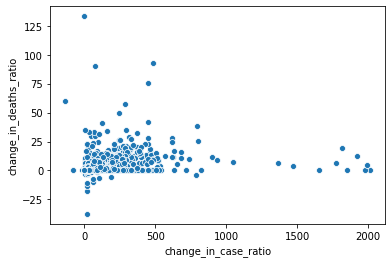

In [229]:
sns.scatterplot(x = 'change_in_case_ratio', y = 'change_in_deaths_ratio', data = hurricanes_and_covid)

In [230]:
km_grid_search(10, X_scaled)

For k = 2, the silhouette score is:
0.7036092307827899
2000.5394063575814

For k = 3, the silhouette score is:
0.6412619117817063
1391.4752269043072

For k = 4, the silhouette score is:
0.5803472303503717
933.1676905752131

For k = 5, the silhouette score is:
0.45589596305755997
717.7519392712717

For k = 6, the silhouette score is:
0.45287622802707467
581.6255558592014

For k = 7, the silhouette score is:
0.46085514746776196
471.09537125099257

For k = 8, the silhouette score is:
0.4586873384442888
416.94265854650575

For k = 9, the silhouette score is:
0.4020804319679705
373.11662169411443



In [240]:
km_covid = KMeans(n_clusters = 5, random_state = 42)

In [241]:
km_covid.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [242]:
hurricanes_and_covid['covid_cluster'] = km_covid.labels_

In [234]:
for i in range(0, hurricanes_and_covid['cluster'].nunique()):
    print(f'Cluster {i}:')
    describe_cluster(i, ['cases', 'deaths'])
    print()

Cluster 0:
The mean for cases is 1517.406876790831.
The mean for deaths is 52.41404011461318.

Cluster 1:
The mean for cases is 24145.555555555555.
The mean for deaths is 413.8888888888889.

Cluster 2:
The mean for cases is 5229.826923076923.
The mean for deaths is 95.04807692307692.

Cluster 3:
The mean for cases is 402.0.
The mean for deaths is 14.0.



In [252]:
hurricanes_and_covid['covid_cluster'].value_counts()

0    918
4    426
1    148
2     11
3      7
Name: covid_cluster, dtype: int64

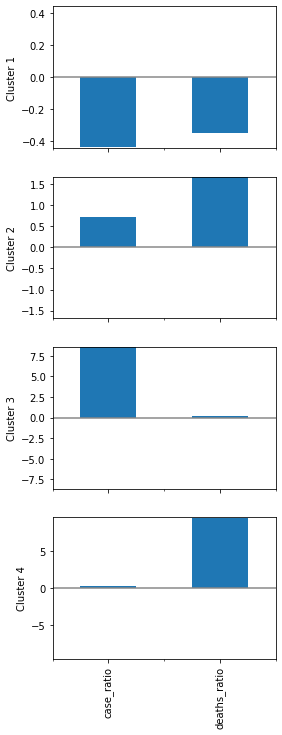

In [253]:
plot_cluster_loadings(km_covid, ['case_ratio', 'deaths_ratio'], 5) 

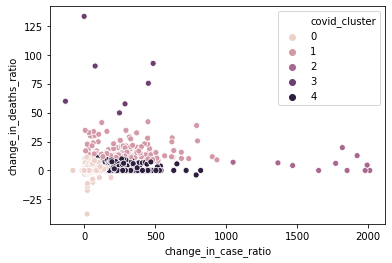

In [267]:
sns.scatterplot(x = 'change_in_case_ratio', y = 'change_in_deaths_ratio', data = hurricanes_and_covid, hue = 'covid_cluster', legend = 'full');

In [262]:
hurricanes_and_covid[hurricanes_and_covid['covid_cluster'] == 2][['state', 'county']]

,state,county
2,Texas,Bee
73,Texas,Karnes
183,Florida,Calhoun
194,Florida,Union
195,Florida,Baker
216,Florida,Franklin
219,Florida,Gulf
222,Florida,Dixie
246,Florida,Taylor
610,Alabama,Clarke


In [259]:
geo_df_usa.columns

Index(['storm_id', 'year', 'number', 'name', 'iso_time', 'nature', 'latitude',
       'longitude', 'wmo_wind(knots)', 'wmo_pressure(mb)', 'wmo_agency',
       'dist2land(km)', 'landfall(km)', 'usa_lat', 'usa_lon', 'usa_status',
       'usa_wind', 'usa_pres', 'storm_category', 'sea_height(ft)',
       'storm_speed(knots)', 'storm_direction(degrees)', 'geometry', 'state',
       'county'],
      dtype='object')

In [264]:
geo_df_usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7145 entries, 0 to 7144
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   storm_id                  7145 non-null   object 
 1   year                      7145 non-null   int64  
 2   number                    7145 non-null   float64
 3   name                      7145 non-null   object 
 4   iso_time                  7145 non-null   object 
 5   nature                    7145 non-null   object 
 6   latitude                  7145 non-null   float64
 7   longitude                 7145 non-null   float64
 8   wmo_wind(knots)           3344 non-null   float64
 9   wmo_pressure(mb)          1419 non-null   float64
 10  wmo_agency                3345 non-null   object 
 11  dist2land(km)             7145 non-null   int64  
 12  landfall(km)              7145 non-null   float64
 13  usa_lat                   6626 non-null   float64
 14  usa_lon 

In [266]:
hurricanes_and_covid[hurricanes_and_covid['change_in_case_ratio'] >= 100]['state'].value_counts()

Georgia           126
Texas             114
Mississippi        71
Tennessee          64
Florida            63
Alabama            63
Louisiana          61
South Carolina     44
North Carolina     40
Arkansas           39
Virginia           22
Illinois           20
Oklahoma           19
Kentucky           17
Missouri           15
Indiana            13
Ohio                5
Kansas              5
Maryland            3
Iowa                2
Pennsylvania        2
West Virginia       2
New Mexico          2
Wisconsin           1
Name: state, dtype: int64

In [269]:
hurricanes_and_covid[hurricanes_and_covid['change_in_case_ratio'] == 0]['state'].value_counts()

Texas             6
West Virginia     5
Maine             2
Pennsylvania      2
Missouri          2
Kentucky          2
North Carolina    2
Michigan          1
Iowa              1
Nebraska          1
Virginia          1
Kansas            1
New York          1
Name: state, dtype: int64

In [273]:
len(hurricanes_and_covid[hurricanes_and_covid['change_in_case_ratio'] >= 100])

813